In [13]:
import os
import joblib
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, plot_importance as lgbm_plot_importance, early_stopping, log_evaluation
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from generate_features import generate_features


In [14]:
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)
os.makedirs("logs", exist_ok=True)

# Also ensure the log CSV exists
log_file = "logs/model_log.csv"
if not os.path.exists(log_file):
    with open(log_file, "w") as f:
        f.write("model_id,model_type,AUC,date,params,notes\n")


In [15]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

X, y, test, feature_names = generate_features(train, test, return_feature_names=True)
X_small, y_small = resample(X, y, n_samples=20000, stratify=y, random_state=42)

# # ⚠️ TEMP: Subsample for debugging speed
# X = X[:20000]
# y = y[:20000]



C:\Users\Jude Younis\AppData\Local\Temp\ipykernel_22628\421899415.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train.csv")
C:\Users\Jude Younis\AppData\Local\Temp\ipykernel_22628\421899415.py:2: DtypeWarning: Columns (15,19) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv("test.csv")


In [16]:
def run_knn_model(model_id, params, notes):
    model_type = "KNN"
    model = KNeighborsClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []

    for train_idx, val_idx in skf.split(X, y):
        model.fit(X[train_idx], y[train_idx])
        val_probs = model.predict_proba(X[val_idx])[:, 1]
        auc = roc_auc_score(y[val_idx], val_probs)
        aucs.append(auc)
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"✅ AUC ({model_id}):", mean_auc)

    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    entry = pd.DataFrame([{ "model_id": model_id, "model_type": model_type, "AUC": mean_auc, "date": datetime.now().strftime("%Y-%m-%d"), "params": str(params), "notes": notes }])
    log_path = "logs/model_log.csv"
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)



In [17]:
def run_logreg_model(model_id, params, notes, feature_names=None):
    model_type = "LogReg"
    model = LogisticRegression(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []

    for train_idx, val_idx in skf.split(X, y):
        model.fit(X[train_idx], y[train_idx])
        val_probs = model.predict_proba(X[val_idx])[:, 1]
        auc = roc_auc_score(y[val_idx], val_probs)
        aucs.append(auc)
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"✅ AUC ({model_id}):", mean_auc)

    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    entry = pd.DataFrame([{ "model_id": model_id, "model_type": model_type, "AUC": mean_auc, "date": datetime.now().strftime("%Y-%m-%d"), "params": str(params), "notes": notes }])
    log_path = "logs/model_log.csv"
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

    if feature_names is not None and hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
        indices = np.argsort(importances)[-10:][::-1]
        plt.barh([feature_names[i] for i in indices], importances[indices])
        plt.xlabel("Feature importance (abs coef)")
        plt.title(f"Top 10 Feature Importances ({model_id})")
        plt.tight_layout()
        plt.show()



In [18]:
def run_svm_model(model_id, params, notes):
    model_type = "SVM"
    model = SVC(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []

    X_small, y_small = resample(X, y, n_samples=5000, stratify=y, random_state=42)

    for train_idx, val_idx in skf.split(X_small, y_small):
        model.fit(X_small[train_idx], y_small[train_idx])
        val_scores = model.decision_function(X_small[val_idx])
        auc = roc_auc_score(y_small[val_idx], val_scores)
        aucs.append(auc)
        test_preds += model.decision_function(test) / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"✅ AUC ({model_id}):", mean_auc)

    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    entry = pd.DataFrame([{ "model_id": model_id, "model_type": model_type, "AUC": mean_auc, "date": datetime.now().strftime("%Y-%m-%d"), "params": str(params), "notes": notes }])
    log_path = "logs/model_log.csv"
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

In [ ]:
def run_adaboost_model(model_id, params, notes, feature_names):
    model_type = "AdaBoost"
    base = DecisionTreeClassifier(max_depth=2)
    model = AdaBoostClassifier(estimator=base, **params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n🟢 Fold {fold + 1}")
        model.fit(X[train_idx], y[train_idx])
        train_probs = model.predict_proba(X[train_idx])[:, 1]
        val_probs = model.predict_proba(X[val_idx])[:, 1]
        train_auc = roc_auc_score(y[train_idx], train_probs)
        val_auc = roc_auc_score(y[val_idx], val_probs)
        print(f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")
        aucs.append(val_auc)
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"\n✅ AUC ({model_id}): {mean_auc:.6f}")

    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    log_path = "logs/model_log.csv"
    entry = pd.DataFrame([{ "model_id": model_id, "model_type": model_type, "AUC": mean_auc, "date": datetime.now().strftime("%Y-%m-%d"), "params": str(params), "notes": notes }])
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:][::-1]
    plt.barh([feature_names[i] for i in indices], importances[indices])
    plt.xlabel("Feature importance")
    plt.title(f"Top 10 Feature Importances ({model_id})")
    plt.tight_layout()
    plt.show()

In [ ]:
def run_xgb_model(model_id, params, notes, feature_names):
    model_type = "XGBoost"
    model = XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n🟢 Fold {fold + 1}")
        model.fit(X[train_idx], y[train_idx])
        train_probs = model.predict_proba(X[train_idx])[:, 1]
        val_probs = model.predict_proba(X[val_idx])[:, 1]
        train_auc = roc_auc_score(y[train_idx], train_probs)
        val_auc = roc_auc_score(y[val_idx], val_probs)
        print(f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")
        aucs.append(val_auc)
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"\n✅ AUC ({model_id}): {mean_auc:.6f}")

    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    log_path = "logs/model_log.csv"
    entry = pd.DataFrame([{ "model_id": model_id, "model_type": model_type, "AUC": mean_auc, "date": datetime.now().strftime("%Y-%m-%d"), "params": str(params), "notes": notes }])
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

    plot_importance(model, max_num_features=10)
    plt.title(f"Top 10 Feature Importances ({model_id})")
    plt.tight_layout()
    plt.show()


In [ ]:
def run_catboost_model(model_id, params, notes, feature_names)::
    model_type = "CatBoost"
    model = CatBoostClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n🟢 Fold {fold + 1}")
        model.fit(X[train_idx], y[train_idx])
        train_probs = model.predict_proba(X[train_idx])[:, 1]
        val_probs = model.predict_proba(X[val_idx])[:, 1]
        train_auc = roc_auc_score(y[train_idx], train_probs)
        val_auc = roc_auc_score(y[val_idx], val_probs)
        print(f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")
        aucs.append(val_auc)
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"\n✅ AUC ({model_id}): {mean_auc:.6f}")

    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    log_path = "logs/model_log.csv"
    entry = pd.DataFrame([{ "model_id": model_id, "model_type": model_type, "AUC": mean_auc, "date": datetime.now().strftime("%Y-%m-%d"), "params": str(params), "notes": notes }])
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

    importances = model.get_feature_importance()
    indices = np.argsort(importances)[-10:][::-1]
    plt.barh([feature_names[i] for i in indices], importances[indices])
    plt.xlabel("Feature importance")
    plt.title(f"Top 10 Feature Importances ({model_id})")
    plt.tight_layout()
    plt.show()


In [22]:
def run_lgbm_model(model_id, params, notes, feature_names):

    model_type = "LightGBM"
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []
    models = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n🟢 Fold {fold + 1}")
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        model = LGBMClassifier(
            **params,
            n_estimators=1000
        )

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[
                early_stopping(stopping_rounds=30),
                log_evaluation(period=100)
            ]
        )

        train_probs = model.predict_proba(X_train)[:, 1]
        val_probs = model.predict_proba(X_val)[:, 1]

        train_auc = roc_auc_score(y_train, train_probs)
        val_auc = roc_auc_score(y_val, val_probs)
        print(f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")

        aucs.append(val_auc)
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits
        models.append(model)

    mean_auc = np.mean(aucs)
    print(f"\n✅ AUC ({model_id}): {mean_auc:.6f}")

    joblib.dump(models[-1], f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    log_path = "logs/model_log.csv"
    entry = pd.DataFrame([{
        "model_id": model_id,
        "model_type": model_type,
        "AUC": mean_auc,
        "date": datetime.now().strftime("%Y-%m-%d"),
        "params": str(params),
        "notes": notes
    }])
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

    # Plot top 10 feature importances with real feature names
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    top_names = [feature_names[i] for i in indices]

    plt.figure(figsize=(8, 5))
    plt.barh(range(10), importances[indices][::-1])
    plt.yticks(range(10), [top_names[i] for i in range(9, -1, -1)])
    plt.xlabel("Feature importance")
    plt.title(f"Top 10 Feature Importances ({model_id})")
    plt.tight_layout()
    plt.show()


In [ ]:
def run_rf_model(model_id, params, notes, feature_names):
    model_type = "RandomForest"
    model = RandomForestClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n🟢 Fold {fold + 1}")
        model.fit(X[train_idx], y[train_idx])
        train_probs = model.predict_proba(X[train_idx])[:, 1]
        val_probs = model.predict_proba(X[val_idx])[:, 1]
        train_auc = roc_auc_score(y[train_idx], train_probs)
        val_auc = roc_auc_score(y[val_idx], val_probs)
        print(f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")
        aucs.append(val_auc)
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"\n✅ AUC ({model_id}): {mean_auc:.6f}")

    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    log_path = "logs/model_log.csv"
    entry = pd.DataFrame([{ "model_id": model_id, "model_type": model_type, "AUC": mean_auc, "date": datetime.now().strftime("%Y-%m-%d"), "params": str(params), "notes": notes }])
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:][::-1]
    plt.barh([feature_names[i] for i in indices], importances[indices])
    plt.xlabel("Feature importance")
    plt.title(f"Top 10 Feature Importances ({model_id})")
    plt.tight_layout()
    plt.show()



🚀 Running lgbm_v1...

🟢 Fold 1
[LightGBM] [Info] Number of positive: 117466, number of negative: 117465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3144
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000009
[LightGBM] [Info] Start training from score 0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.438578
[200]	valid_0's binary_logloss: 0.430723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9101 | Val AUC: 0.8842


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 2
[LightGBM] [Info] Number of positive: 117466, number of negative: 117465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3147
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 180
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000009
[LightGBM] [Info] Start training from score 0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.443761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's binary_logloss: 0.435904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9043 | Val AUC: 0.8809


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 3
[LightGBM] [Info] Number of positive: 117465, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.149186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3144
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[LightGBM] [Info] Start training from score -0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.440519
[200]	valid_0's binary_logloss: 0.4323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9016 | Val AUC: 0.8834


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 4
[LightGBM] [Info] Number of positive: 117465, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3141
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 178
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[LightGBM] [Info] Start training from score -0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.44096
[200]	valid_0's binary_logloss: 0.433476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9087 | Val AUC: 0.8824


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 5
[LightGBM] [Info] Number of positive: 117466, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3144
[LightGBM] [Info] Number of data points in the train set: 234932, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.440138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's binary_logloss: 0.431938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9078 | Val AUC: 0.8839


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



✅ AUC (lgbm_v1): 0.882953


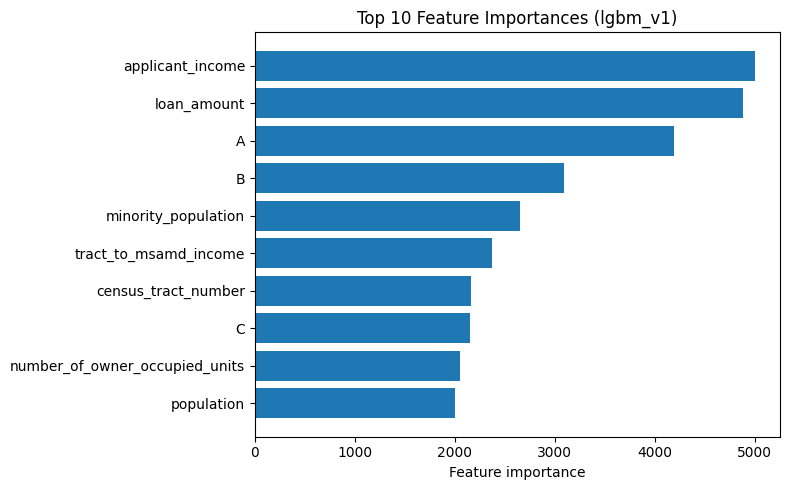


🚀 Running lgbm_v2...

🟢 Fold 1
[LightGBM] [Info] Number of positive: 117466, number of negative: 117465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3144
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000009
[LightGBM] [Info] Start training from score 0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.443225
[200]	valid_0's binary_logloss: 0.43169
[300]	valid_0's binary_logloss: 0.428628
[400]	valid_0's binary_logloss: 0.427788
[500]	valid_0's binary_logloss: 0.427342
[600]	valid_0's binary_logloss: 0.426945
[700]	valid_0's binary_logloss: 0.426725
[LightGBM] [Warning] No further splits with positive gain, be

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9083 | Val AUC: 0.8840


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 2
[LightGBM] [Info] Number of positive: 117466, number of negative: 117465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3147
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 180
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000009
[LightGBM] [Info] Start training from score 0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.447884
[200]	valid_0's binary_logloss: 0.437042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's binary_logloss: 0.43397
[400]	valid_0's binary_logloss: 0.432962
[LightGBM] [Warning] No further splits with positive gai

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9056 | Val AUC: 0.8809


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 3
[LightGBM] [Info] Number of positive: 117465, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.166350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3144
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[LightGBM] [Info] Start training from score -0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.445036
[200]	valid_0's binary_logloss: 0.432895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's binary_logloss: 0.429632
[400]	valid_0's binary_logloss: 0.428328
[500]	valid_0's binary_logloss: 0.427712
[LightGBM] [

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9050 | Val AUC: 0.8838


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 4
[LightGBM] [Info] Number of positive: 117465, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3141
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 178
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[LightGBM] [Info] Start training from score -0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.445947
[200]	valid_0's binary_logloss: 0.434424
[300]	valid_0's binary_logloss: 0.431299
[400]	valid_0's binary_logloss: 0.430212
[500]	valid_0's binary_logloss: 0.429773
[600]	valid_0's binary_logloss: 0.429538
[700]	valid_0's binary_logloss: 0.429365
[800]	valid_0's binary_logloss: 0.429288
Early stopping, best iteration is:
[782

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9090 | Val AUC: 0.8826


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 5
[LightGBM] [Info] Number of positive: 117466, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3144
[LightGBM] [Info] Number of data points in the train set: 234932, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.44496
[200]	valid_0's binary_logloss: 0.433382
[300]	valid_0's binary_logloss: 0.429805
[400]	valid_0's binary_logloss: 0.428807
[500]	valid_0's binary_logloss: 0.428278
[600]	valid_0's binary_logloss: 0.428101
[700]	valid_0's binary_logloss: 0.427883
[800]	valid_0's binary_logloss: 0.427773
Early stopping, best iteration is:
[787]	valid_0's binary_logloss: 0.427745


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9086 | Val AUC: 0.8836


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



✅ AUC (lgbm_v2): 0.882975


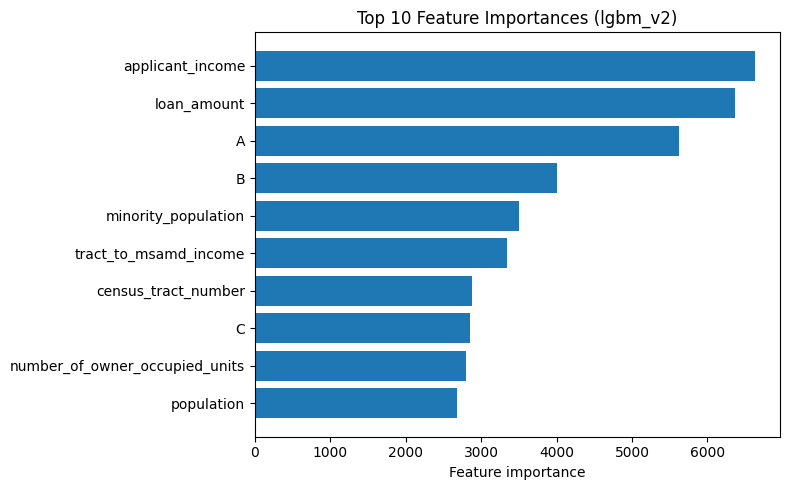


🚀 Running lgbm_v3...

🟢 Fold 1
[LightGBM] [Info] Number of positive: 117466, number of negative: 117465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3144
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000009
[LightGBM] [Info] Start training from score 0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.447391
[200]	valid_0's binary_logloss: 0.433023
[300]	valid_0's binary_logloss: 0.428814
[400]	valid_0's binary_logloss: 0.427803
[500]	valid_0's binary_logloss: 0.427428
[600]	valid_0's binary_logloss: 0.427333
Early stopping, best iteration is:
[579]	valid_0's binary_logloss: 0.42729


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9037 | Val AUC: 0.8837


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 2
[LightGBM] [Info] Number of positive: 117466, number of negative: 117465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3147
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 180
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000009
[LightGBM] [Info] Start training from score 0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.451766
[200]	valid_0's binary_logloss: 0.438331
[300]	valid_0's binary_logloss: 0.43427
[400]	valid_0's binary_logloss: 0.433233
[500]	valid_0's binary_logloss: 0.432771
[600]	valid_0's binary_logloss: 0.432464
Early stopping, best iteration is:
[576]	valid_0's binary_logloss: 0.432419


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9043 | Val AUC: 0.8807


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 3
[LightGBM] [Info] Number of positive: 117465, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3144
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[LightGBM] [Info] Start training from score -0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.449453
[200]	valid_0's binary_logloss: 0.434324
[300]	valid_0's binary_logloss: 0.42994
[400]	valid_0's binary_logloss: 0.428551
[500]	valid_0's binary_logloss: 0.427927
[600]	valid_0's binary_logloss: 0.427655
Early stopping, best iteration is:
[637]	valid_0's binary_logloss: 0.427569


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9055 | Val AUC: 0.8835


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 4
[LightGBM] [Info] Number of positive: 117465, number of negative: 117466
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3141
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 178
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[LightGBM] [Info] Start training from score -0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.44929
[200]	valid_0's binary_logloss: 0.435662
[300]	valid_0's binary_logloss: 0.431743
[400]	valid_0's binary_logloss: 0.430566
[500]	valid_0's binary_logloss: 0.430192
[600]	valid_0's binary_logloss: 0.429874
Early stopping, best iteration is:
[659]	valid_0's binary_logloss: 0.429735


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9070 | Val AUC: 0.8823


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 5
[LightGBM] [Info] Number of positive: 117466, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3144
[LightGBM] [Info] Number of data points in the train set: 234932, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.448958
[200]	valid_0's binary_logloss: 0.434593
[300]	valid_0's binary_logloss: 0.430225
[400]	valid_0's binary_logloss: 0.429041
[500]	valid_0's binary_logloss: 0.428499
[600]	valid_0's binary_logloss: 0.428233
Early stopping, best iteration is:
[595]	valid_0's binary_logloss: 0.428219


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9042 | Val AUC: 0.8834


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



✅ AUC (lgbm_v3): 0.882708


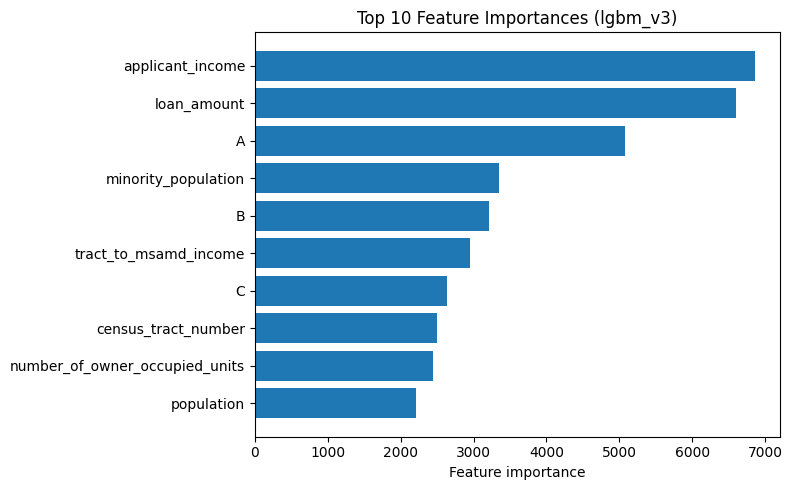


🚀 Running lgbm_v4...

🟢 Fold 1
[LightGBM] [Info] Number of positive: 117466, number of negative: 117465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3144
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000009
[LightGBM] [Info] Start training from score 0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.462277
[200]	valid_0's binary_logloss: 0.441977
[300]	valid_0's binary_logloss: 0.435961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid_0's binary_logloss: 0.433263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.8912 | Val AUC: 0.8829


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 2
[LightGBM] [Info] Number of positive: 117466, number of negative: 117465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3147
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 180
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000009
[LightGBM] [Info] Start training from score 0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.466736
[200]	valid_0's binary_logloss: 0.446965
[300]	valid_0's binary_logloss: 0.441167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid_0's binary_logloss: 0.438549
[LightGBM] [Warning] No further splits with positive ga

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.8918 | Val AUC: 0.8799


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 3
[LightGBM] [Info] Number of positive: 117465, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3144
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[LightGBM] [Info] Start training from score -0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.464235
[200]	valid_0's binary_logloss: 0.443821
[300]	valid_0's binary_logloss: 0.437606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.8910 | Val AUC: 0.8826


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 4
[LightGBM] [Info] Number of positive: 117465, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3141
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 178
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[LightGBM] [Info] Start training from score -0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.463228
[200]	valid_0's binary_logloss: 0.443765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's binary_logloss: 0.43824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.8917 | Val AUC: 0.8815


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 5
[LightGBM] [Info] Number of positive: 117466, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3144
[LightGBM] [Info] Number of data points in the train set: 234932, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.463556
[200]	valid_0's binary_logloss: 0.443306
[300]	valid_0's binary_logloss: 0.437163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.8912 | Val AUC: 0.8828


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



✅ AUC (lgbm_v4): 0.881943


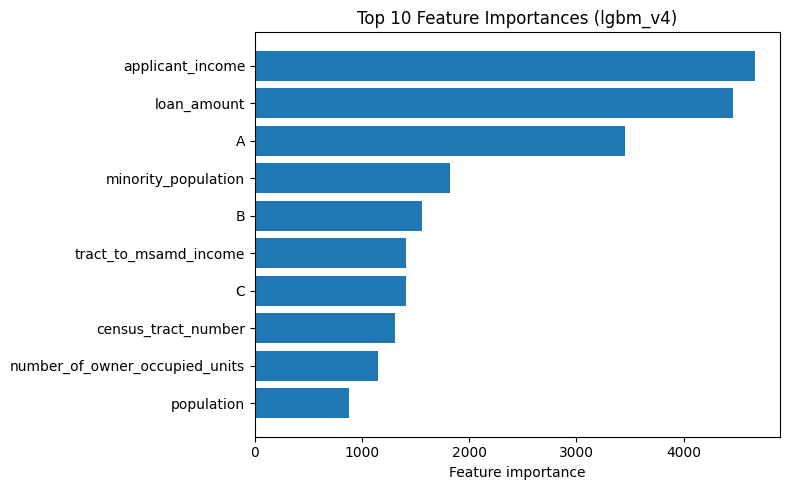


🚀 Running lgbm_v5...

🟢 Fold 1
[LightGBM] [Info] Number of positive: 117466, number of negative: 117465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3144
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000009
[LightGBM] [Info] Start training from score 0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.507302
[200]	valid_0's binary_logloss: 0.464612
[300]	valid_0's binary_logloss: 0.451049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.8825 | Val AUC: 0.8801


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 2
[LightGBM] [Info] Number of positive: 117466, number of negative: 117465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3147
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 180
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000009
[LightGBM] [Info] Start training from score 0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.510877
[200]	valid_0's binary_logloss: 0.469105
[300]	valid_0's binary_logloss: 0.455939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.8832 | Val AUC: 0.8770


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 3
[LightGBM] [Info] Number of positive: 117465, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3144
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[LightGBM] [Info] Start training from score -0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.50885
[200]	valid_0's binary_logloss: 0.466574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.8826 | Val AUC: 0.8794


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 4
[LightGBM] [Info] Number of positive: 117465, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3141
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 178
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[LightGBM] [Info] Start training from score -0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.50839
[200]	valid_0's binary_logloss: 0.466036
[300]	valid_0's binary_logloss: 0.452643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.8827 | Val AUC: 0.8789


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 5
[LightGBM] [Info] Number of positive: 117466, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3144
[LightGBM] [Info] Number of data points in the train set: 234932, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.508309
[200]	valid_0's binary_logloss: 0.465835
[300]	valid_0's binary_logloss: 0.452411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.8826 | Val AUC: 0.8799


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



✅ AUC (lgbm_v5): 0.879053


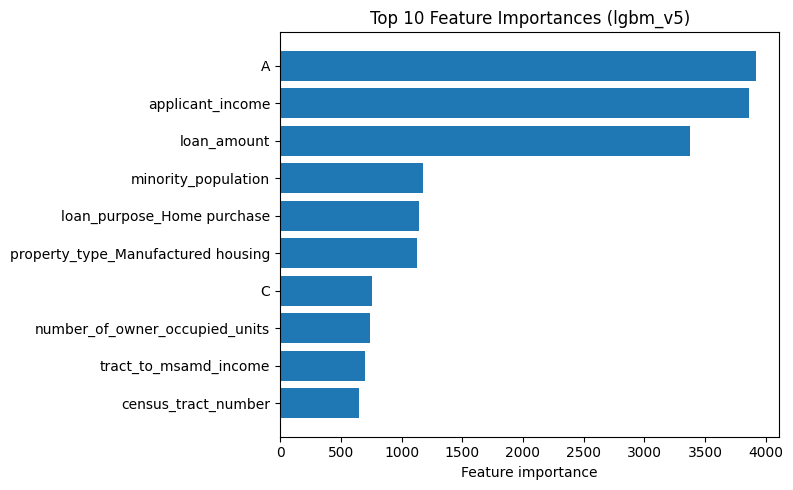


🚀 Running xgb_v1...


TypeError: run_xgb_model() missing 3 required positional arguments: 'y', 'test', and 'feature_names'

In [ ]:
# Parameter grids
lgbm_param_grid = [
    {"num_leaves": 60, "max_depth": 8, "learning_rate": 0.04, "subsample": 0.85, "colsample_bytree": 0.9, "random_state": 42},
    {"num_leaves": 80, "max_depth": 10, "learning_rate": 0.03, "subsample": 0.9, "colsample_bytree": 0.85, "random_state": 42},
    {"num_leaves": 100, "max_depth": 12, "learning_rate": 0.025, "subsample": 0.95, "colsample_bytree": 0.9, "random_state": 42},
    {"num_leaves": 40, "max_depth": 6, "learning_rate": 0.02, "subsample": 0.85, "colsample_bytree": 0.95, "random_state": 42},
    {"num_leaves": 30, "max_depth": 5, "learning_rate": 0.01, "subsample": 0.9, "colsample_bytree": 1.0, "random_state": 42}
]

catboost_param_grid = [
    {"iterations": 500, "depth": 6, "learning_rate": 0.03, "loss_function": "Logloss", "verbose": 0, "random_seed": 42},
    {"iterations": 600, "depth": 8, "learning_rate": 0.025, "loss_function": "Logloss", "verbose": 0, "random_seed": 42},
    {"iterations": 700, "depth": 7, "learning_rate": 0.02, "loss_function": "Logloss", "verbose": 0, "random_seed": 42}
]
xgb_param_grid = [
    {"n_estimators": 10000, "max_depth": 6, "learning_rate": 0.035, "subsample": 0.9, "colsample_bytree": 0.9, "eval_metric": "logloss", "random_state": 42, "use_label_encoder": False},
    {"n_estimators": 10000, "max_depth": 5, "learning_rate": 0.03, "subsample": 0.85, "colsample_bytree": 0.8, "eval_metric": "logloss", "random_state": 42, "use_label_encoder": False},
    {"n_estimators": 10000, "max_depth": 4, "learning_rate": 0.02, "subsample": 1.0, "colsample_bytree": 1.0, "eval_metric": "logloss", "random_state": 42, "use_label_encoder": False},
    {"n_estimators": 10000, "max_depth": 5, "learning_rate": 0.015, "subsample": 0.9, "colsample_bytree": 0.85, "eval_metric": "logloss", "random_state": 42, "use_label_encoder": False},
    {"n_estimators": 10000, "max_depth": 3, "learning_rate": 0.01, "subsample": 0.95, "colsample_bytree": 0.95, "eval_metric": "logloss", "random_state": 42, "use_label_encoder": False}
]

rf_param_grid = [
    {"n_estimators": 300, "max_depth": 12, "min_samples_leaf": 2, "max_features": "sqrt", "bootstrap": True, "random_state": 42, "n_jobs": -1},
    {"n_estimators": 400, "max_depth": 15, "min_samples_leaf": 2, "max_features": 0.8, "bootstrap": True, "random_state": 42, "n_jobs": -1}
]
adaboost_param_grid = [
    {"n_estimators": 300, "learning_rate": 0.1, "random_state": 42},
    {"n_estimators": 500, "learning_rate": 0.05, "random_state": 42}
]
logreg_param_grid = [
    {"solver": "liblinear", "C": 1.0, "max_iter": 200},
    {"solver": "liblinear", "C": 0.5, "max_iter": 200}
]
svm_param_grid = [
    {"C": 1.0, "kernel": "linear", "probability": False, "random_state": 42},
    {"C": 0.5, "kernel": "linear", "probability": False, "random_state": 42}
]
knn_param_grid = [
    {"n_neighbors": 5},
    {"n_neighbors": 7}
]

model_configs = [
    ("lgbm", run_lgbm_model, lgbm_param_grid, X, y, True),
    ("xgb", run_xgb_model, xgb_param_grid, X, y, True),
    ("rf", run_rf_model, rf_param_grid, X, y, True),
    ("catboost", run_catboost_model, catboost_param_grid, X, y, False),
    ("adaboost", run_adaboost_model, adaboost_param_grid, X, y, True),
    ("logreg", run_logreg_model, logreg_param_grid, X, y, True),
    ("svm", run_svm_model, svm_param_grid, X_small, y_small, False),
    ("knn", run_knn_model, knn_param_grid, X_small, y_small, False)
]

# Run all model configs with all param sets
for model_prefix, func, param_list, X_used, y_used, pass_features in model_configs:
    for i, params in enumerate(param_list):
        model_id = f"{model_prefix}_v{i+1}"
        print(f"\n🚀 Running {model_id}...")

        try:
            if pass_features:
                func(model_id, params, f"{model_prefix.upper()} config #{i+1}", feature_names)
            else:
                func(model_id, params, f"{model_prefix.upper()} config #{i+1}")
        except Exception as e:
            print(f"❌ ERROR in {model_id}: {e}")
            continue  # Move to the next config

